# Canada Birth Probability Analysis

## 1. Retrieve and process public data

###  Import Libraries

In [1]:
# Importing libraries
import pandas as pd
import requests
import os

# Setting up directories
project_dir = os.path.abspath("..")
data_dir = os.path.join(project_dir, "data")
db_dir = os.path.join(project_dir, "db")
output_dir = os.path.join(project_dir, "output")

print("Project directories:")
print(data_dir)
print(db_dir)
print(output_dir)


Project directories:
/Users/nikkusmac/Desktop/canada_birth_probability/data
/Users/nikkusmac/Desktop/canada_birth_probability/db
/Users/nikkusmac/Desktop/canada_birth_probability/output


### Download and Save API Data

In [2]:
# Defining API endpoints
birth_rate_url = "https://api.worldbank.org/v2/country/all/indicator/SP.DYN.CBRT.IN?format=json&per_page=20000"
population_url = "https://api.worldbank.org/v2/country/all/indicator/SP.POP.TOTL?format=json&per_page=20000"

# Fetching data from the APIs
birth_resp = requests.get(birth_rate_url)
pop_resp = requests.get(population_url)

# Converting to JSON
birth_json = birth_resp.json()
pop_json = pop_resp.json()

# Step 4: Save to data/ folder
birth_path = os.path.join(data_dir, "birth_rate_raw.json")
pop_path = os.path.join(data_dir, "population_raw.json")

with open(birth_path, "w") as f:
    import json
    json.dump(birth_json, f)

with open(pop_path, "w") as f:
    json.dump(pop_json, f)

print("Data saved successfully")
print(type(birth_json))     
print(len(birth_json))      
print(type(birth_json[1]))  
print(len(birth_json[1]))   


Data saved successfully
<class 'list'>
2
<class 'list'>
17290


### Parse and Clean Both Datasets

In [3]:
import json

# Checking structure of one record from the birth data
print(json.dumps(birth_json[1][0], indent=2))
print(json.dumps(pop_json[1][0], indent=2))

def parse_world_bank_json(json_data, indicator_name):
    records = []
    for entry in json_data[1]:
        try:
            country = entry["country"]["value"]
            code = entry["countryiso3code"]        
            year = int(entry["date"])
            value = entry["value"]

            if code and len(code) == 3 and value is not None:
                records.append({
                    "country": country,
                    "code": code,
                    "year": year,
                    indicator_name: value
                })
        except (KeyError, TypeError, ValueError):
            continue

    return pd.DataFrame(records)

birth_df = parse_world_bank_json(birth_json, "birth_rate")
pop_df = parse_world_bank_json(pop_json, "population")

print(birth_df.columns)
print(pop_df.columns)



{
  "indicator": {
    "id": "SP.DYN.CBRT.IN",
    "value": "Birth rate, crude (per 1,000 people)"
  },
  "country": {
    "id": "ZH",
    "value": "Africa Eastern and Southern"
  },
  "countryiso3code": "AFE",
  "date": "2024",
  "value": null,
  "unit": "",
  "obs_status": "",
  "decimal": 0
}
{
  "indicator": {
    "id": "SP.POP.TOTL",
    "value": "Population, total"
  },
  "country": {
    "id": "ZH",
    "value": "Africa Eastern and Southern"
  },
  "countryiso3code": "AFE",
  "date": "2024",
  "value": 769294618,
  "unit": "",
  "obs_status": "",
  "decimal": 0
}
Index(['country', 'code', 'year', 'birth_rate'], dtype='object')
Index(['country', 'code', 'year', 'population'], dtype='object')


###  Merge and Calculate Estimated Births

In [4]:
# Merging birth rate and population data
merged_df = pd.merge(birth_df, pop_df, on=["code", "year"], how="inner")

# Filtering for years 2000 to 2020
merged_df = merged_df[(merged_df["year"] >= 2000) & (merged_df["year"] <= 2020)]

# Dropping rows with missing values
merged_df.dropna(subset=["birth_rate", "population"], inplace=True)

# Calculating estimated number of births
merged_df["estimated_births"] = (merged_df["birth_rate"] / 1000) * merged_df["population"]

# Preview
merged_df.head()


,country_x,code,year,birth_rate,country_y,population,estimated_births
3,Africa Eastern and Southern,AFE,2020,34.010470,Africa Eastern and Southern,694446100,2.361844e+07
4,Africa Eastern and Southern,AFE,2019,34.335881,Africa Eastern and Southern,675950189,2.320935e+07
5,Africa Eastern and Southern,AFE,2018,34.583615,Africa Eastern and Southern,657801085,2.274914e+07
6,Africa Eastern and Southern,AFE,2017,34.813992,Africa Eastern and Southern,640058741,2.228300e+07
7,Africa Eastern and Southern,AFE,2016,35.067866,Africa Eastern and Southern,623369401,2.186023e+07


## 2. Load the data into a local SQL database (e.g., SQLite) for querying.


### Save the Cleaned Data to SQLite

In [5]:
import sqlite3

# Defining the DB path
db_path = os.path.join(db_dir, "birth_data.sqlite")

# Connecting to SQLite
conn = sqlite3.connect(db_path)

# Saving to table
merged_df.to_sql("births", conn, if_exists="replace", index=False)

# Closing the connection
conn.close()

print(f"Data saved to SQLite at: {db_path}")


Data saved to SQLite at: /Users/nikkusmac/Desktop/canada_birth_probability/db/birth_data.sqlite


## 3. Calculate the probability (as a percentage or ratio) that a person born in a given year was born in Canada, compared to the rest of the world.

### Probability of being born in Canada by year

In [6]:
# Reconnecting to the database
conn = sqlite3.connect(db_path)

# Query births in Canada for all years
canada_df = pd.read_sql("""
SELECT year, estimated_births 
FROM births 
WHERE code = 'CAN'
ORDER BY year
""", conn)

# Query global births for all years
world_df = pd.read_sql("""
SELECT year, SUM(estimated_births) as world_births 
FROM births 
GROUP BY year
ORDER BY year
""", conn)

# Merge and calculate probability per year
prob_df = pd.merge(canada_df, world_df, on="year")
prob_df["probability"] = prob_df["estimated_births"] / prob_df["world_births"]
prob_df["percent"] = prob_df["probability"] * 100

# Optional: preview results
print("\nProbability of being born in Canada by year:")
print(prob_df[["year", "probability", "percent"]])


conn.close()



Probability of being born in Canada by year:
    year  probability   percent
0   2000     0.000235  0.023547
1   2001     0.000240  0.024007
2   2002     0.000236  0.023604
3   2003     0.000240  0.024004
4   2004     0.000241  0.024089
5   2005     0.000244  0.024379
6   2006     0.000252  0.025154
7   2007     0.000258  0.025837
8   2008     0.000263  0.026272
9   2009     0.000262  0.026164
10  2010     0.000258  0.025842
11  2011     0.000252  0.025152
12  2012     0.000250  0.024959
13  2013     0.000253  0.025289
14  2014     0.000253  0.025330
15  2015     0.000254  0.025385
16  2016     0.000251  0.025078
17  2017     0.000250  0.024986
18  2018     0.000253  0.025274
19  2019     0.000253  0.025338
20  2020     0.000251  0.025149


- The probability of being born in Canada has remained **relatively stable** between **0.0235% and 0.0263%** over the 21-year period.
- The **peak occurred in 2008**, when approximately **0.0263%** of all births worldwide were in Canada.
- Despite small fluctuations, the probability has hovered around **0.025%**, indicating that **Canada consistently accounts for about 1 in 4,000 global births**.


### Visualize Canada’s Birth Probability Over Time

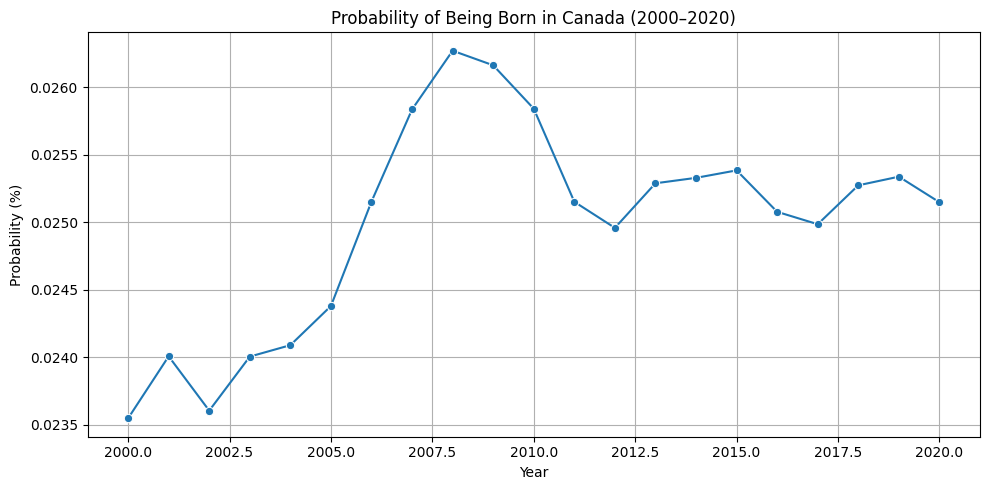

In [7]:
# Reconnecting
conn = sqlite3.connect(db_path)

# Quering births in Canada for all years
canada_df = pd.read_sql("""
SELECT year, estimated_births 
FROM births 
WHERE code = 'CAN'
ORDER BY year
""", conn)

# Quering global births for all years
world_df = pd.read_sql("""
SELECT year, SUM(estimated_births) as world_births 
FROM births 
GROUP BY year
ORDER BY year
""", conn)

conn.close()

# Merging and calculating probability
prob_df = pd.merge(canada_df, world_df, on="year")
prob_df["probability"] = prob_df["estimated_births"] / prob_df["world_births"]
prob_df["percent"] = prob_df["probability"] * 100

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.lineplot(data=prob_df, x="year", y="percent", marker="o")
plt.title("Probability of Being Born in Canada (2000–2020)")
plt.ylabel("Probability (%)")
plt.xlabel("Year")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "canada_birth_probability_trend.png"))
plt.show()


## 4. Appendix
- Undertsanding the dataset
- Canada vs. World Birth Trends
- Canada's Birth Rate Trend (2000–2020)
- Canada's Population Trend (2000–2020)
- Highest and Lowest probability of being born in Canada
- Forecasting Canada's Birth Rate (2000–2030)

### Undertsanding the dataset

In [8]:
# merged_df
# merged_df.shape
# merged_df["country_x"].nunique()        # number of unique countries
# merged_df["country_x"].unique()         # actual country names
# sorted(merged_df["country_x"].unique())
# merged_df["year"].nunique()            # number of unique years
# merged_df["year"].unique()             # list of years
# merged_df.describe()

### Canada vs. World Birth Trends

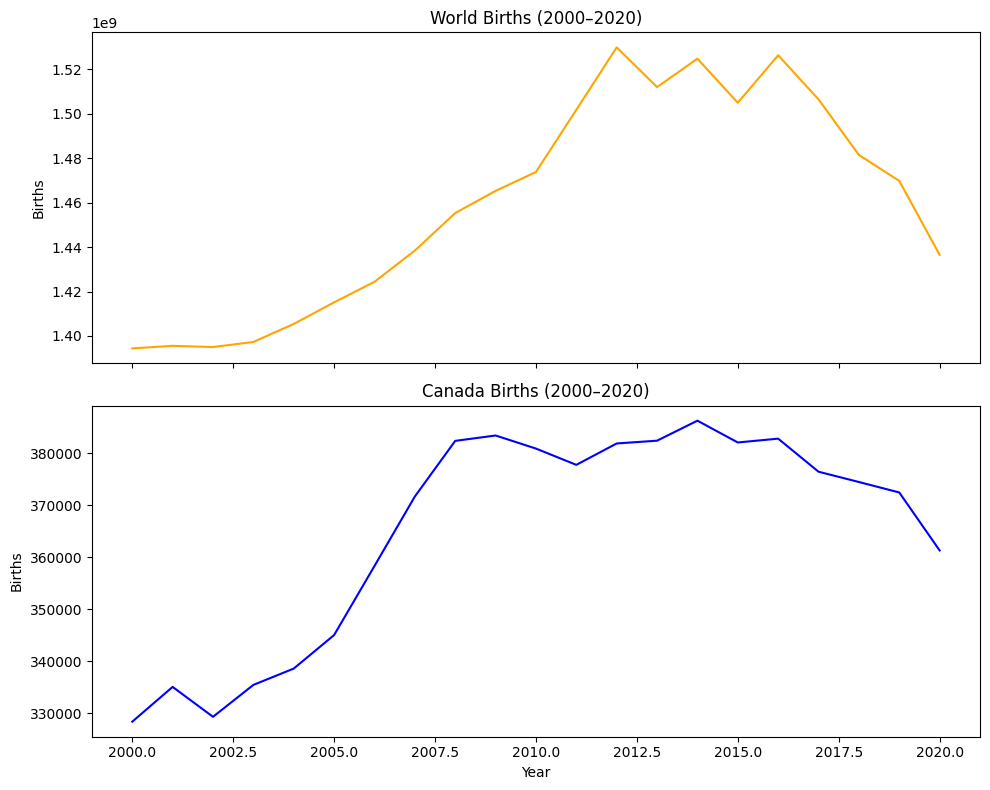

In [9]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

sns.lineplot(data=prob_df, x="year", y="world_births", ax=axes[0], color='orange')
axes[0].set_title("World Births (2000–2020)")
axes[0].set_ylabel("Births")

sns.lineplot(data=prob_df, x="year", y="estimated_births", ax=axes[1], color='blue')
axes[1].set_title("Canada Births (2000–2020)")
axes[1].set_ylabel("Births")
axes[1].set_xlabel("Year")

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "canada_vs_world_births_split.png"))
plt.show()


### Canada's Birth Rate Trend (2000–2020)

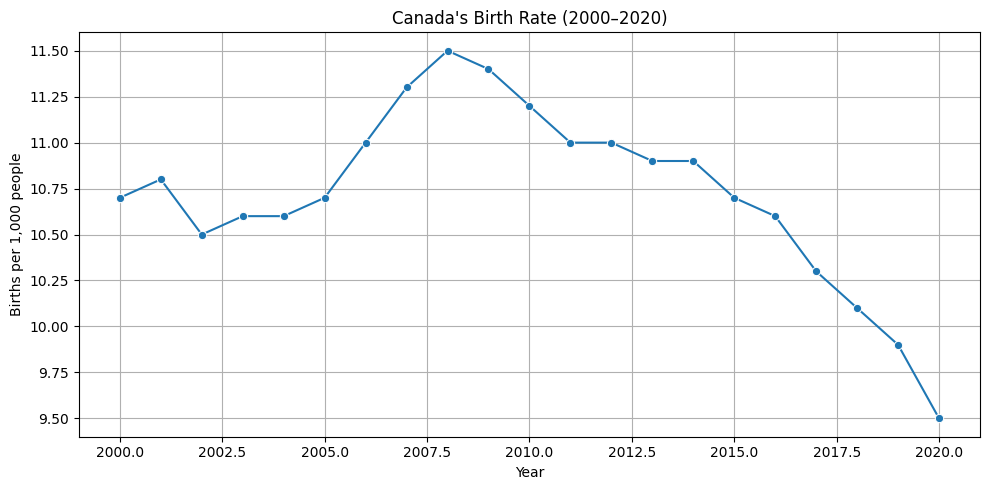

In [10]:
canada_rate = birth_df[(birth_df["code"] == "CAN") & 
                       (birth_df["year"].between(2000, 2020))].sort_values("year")


plt.figure(figsize=(10, 5))
sns.lineplot(data=canada_rate, x="year", y="birth_rate", marker="o")
plt.title("Canada's Birth Rate (2000–2020)")
plt.ylabel("Births per 1,000 people")
plt.xlabel("Year")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "canada_birth_rate_trend.png"))
plt.show()


###  Canada's Population Trend (2000–2020)

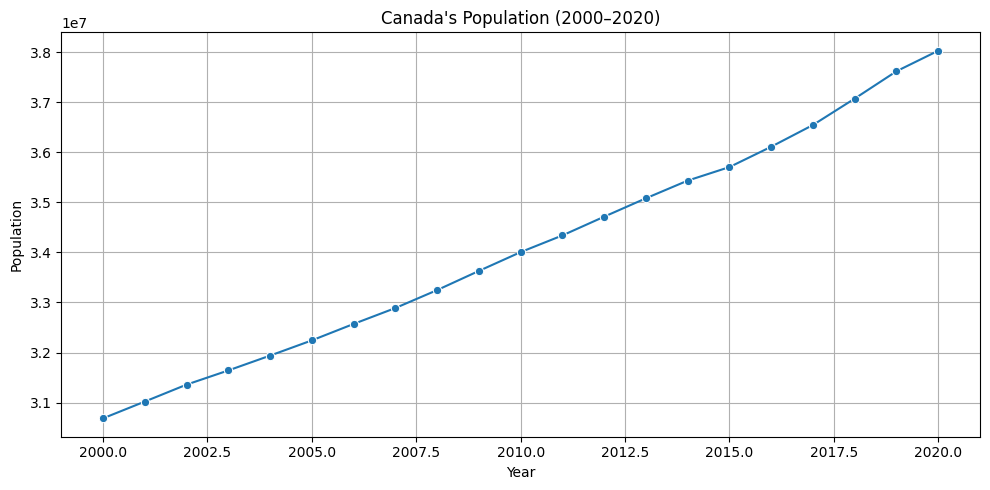

In [11]:
canada_pop = pop_df[(pop_df["code"] == "CAN") & 
                       (pop_df["year"].between(2000, 2020))].sort_values("year")

plt.figure(figsize=(10, 5))
sns.lineplot(data=canada_pop, x="year", y="population", marker="o")
plt.title("Canada's Population (2000–2020)")
plt.ylabel("Population")
plt.xlabel("Year")
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "canada_population_trend.png"))
plt.show()


### Highest and Lowest probability of being born in Canada

In [12]:
max_row = prob_df.loc[prob_df["percent"].idxmax()]
min_row = prob_df.loc[prob_df["percent"].idxmin()]

print(f"Highest probability of being born in Canada: {max_row['percent']:.4f}% in {int(max_row['year'])}")
print(f"Lowest probability of being born in Canada: {min_row['percent']:.4f}% in {int(min_row['year'])}")


Highest probability of being born in Canada: 0.0263% in 2008
Lowest probability of being born in Canada: 0.0235% in 2000


### Goal is to Forecast Canada's Birth Rate (2000–2030)

Using Canada’s historical birth rate data (2000–2020) to:

- Fitting a regression model to understand the trend.
- Forecasting the birth rate up to the year 2030 using the fitted model.
- Visualizing the trend and projections to interpret patterns and potential future outcomes.


In [13]:
canada_rate = birth_df[birth_df["code"] == "CAN"].copy()
canada_rate = canada_rate[canada_rate["year"].between(2000, 2020)]
canada_rate = canada_rate.sort_values("year")


In [14]:
!pip install scikit-learn
from sklearn.linear_model import LinearRegression
import numpy as np

# Prepare features and target
X = canada_rate["year"].values.reshape(-1, 1)  # e.g., [[2000], [2001], ...]
y = canada_rate["birth_rate"].values

# Fit model
model = LinearRegression()
model.fit(X, y)

# Print model parameters
slope = model.coef_[0]
intercept = model.intercept_
print(f"Model: birth_rate = {intercept:.3f} + {slope:.4f} × year")



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Model: birth_rate = 84.859 + -0.0369 × year


In [15]:
# Create future years (2021–2030)
future_years = np.arange(2000, 2031).reshape(-1, 1)
predicted_birth_rate = model.predict(future_years)

# Combine for plotting
forecast_df = pd.DataFrame({
    "year": future_years.flatten(),
    "birth_rate": predicted_birth_rate
})


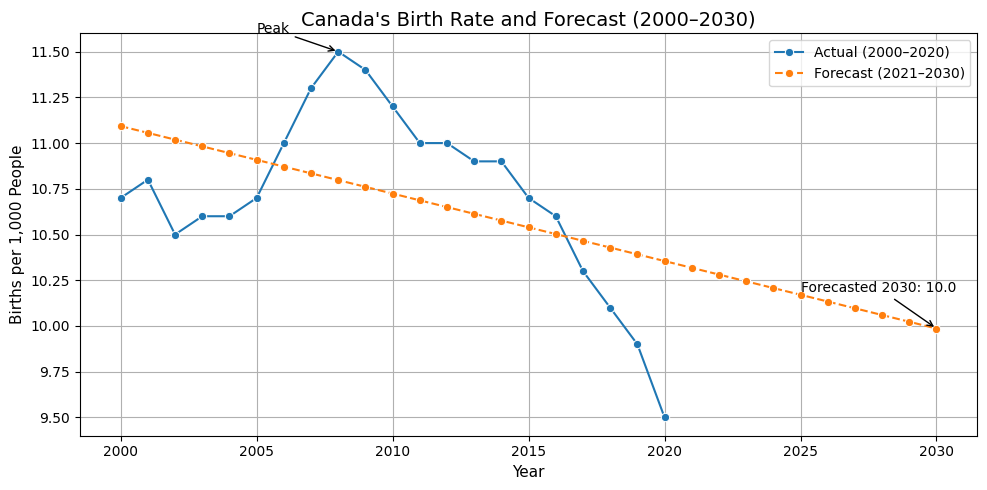

In [16]:
plt.figure(figsize=(10, 5))

# Plot actual data
sns.lineplot(data=canada_rate, x="year", y="birth_rate", label="Actual (2000–2020)", marker="o")

# Plot forecast
sns.lineplot(data=forecast_df, x="year", y="birth_rate", label="Forecast (2021–2030)", linestyle="--", marker="o")
plt.annotate("Peak", xy=(2008, 11.5), xytext=(2005, 11.6),
             arrowprops=dict(arrowstyle="->"), fontsize=10)
plt.annotate("Forecasted 2030: {:.1f}".format(forecast_df.iloc[-1]["birth_rate"]),
             xy=(2030, forecast_df.iloc[-1]["birth_rate"]),
             xytext=(2025, forecast_df.iloc[-1]["birth_rate"] + 0.2),
             arrowprops=dict(arrowstyle="->"), fontsize=10)

plt.ylabel("Births per 1,000 People", fontsize=11)
plt.xlabel("Year", fontsize=11)
plt.title("Canada's Birth Rate and Forecast (2000–2030)", fontsize=14)

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "canada_birth_rate_forecast.png"))
plt.show()



#### Linear Regression Model

We applied a linear regression model to Canada’s birth rate data from 2000 to 2020:
**Birth Rate = 84.859 − 0.0369 × Year**

This equation indicates that Canada’s birth rate is declining at an average of **0.0369 births per 1,000 people per year**.

#### Forecast Insights

- **Peak Birth Rate:** The birth rate peaked in **2008** at approximately **11.5 births per 1,000 people**.
- **2020 Status:** By 2020, the birth rate had declined to **9.5**.
- **Forecasted 2030:** Based on the model, the birth rate in **2030 is projected to be 10.0 births per 1,000 people**.

#### Interpretation

- The steady downward trend is consistent with other developed nations, often driven by **urbanization**, **higher education levels**, **increased cost of living**, and **delayed family planning**.
- If the trend continues, Canada may face **demographic challenges** such as a **shrinking labor force**, **greater dependency ratios**, and **increased demand for eldercare services**.
- While the linear model provides a clear overall trend, it may not capture **non-linear behaviors**, **policy interventions**, or **economic shifts** that influence fertility rates in the short term.
